# Hackathon #1 - Binary Classification - Template
Always check the [Reference Document](https://docs.google.com/document/d/1A-1-UK9ol4tegfU4YQySEiBXBeqbx_tu1qdmiMAzNCM/edit?usp=sharing) for all information ;) 

Remember to keep your workflow consistent!

## Regarding the Data
- The dataset can be loaded with `load_data()` (check the already provided code below). It will output two dataframes:
  - `train`: labeled dataset (with target) 
  - `test`: unlabeled dataset (target is not available)
- You will use the `train` data to do your magic! When you are finished and have a predictive model you will have to make predictions using the `test` data and submit it to our platform (where you will get a AUC value - kind of what happens in Kaggle competitions). Check the file `submission_example.csv` for an example and the [Reference Document](https://docs.google.com/document/d/1A-1-UK9ol4tegfU4YQySEiBXBeqbx_tu1qdmiMAzNCM/edit?usp=sharing) for further information.
- You can and should perform train-test splits on the `train` data that you have available. Cross-validation is highly recommended. 
- The target name is `TomorrowRainForecast`: it is either 1 (rains tomorrow) and 0 (does not rain tomorrow).
- The `ID` is the identification variable which is very important for keeping track of the predictions you will make on the `test` data.

*Good luck,  
LDSA team*

In [ ]:
%load_ext autoreload

In [10]:
# some useful imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.linear_model import LogisticRegression

from utils import read_and_process
% autoreload 2
%matplotlib inline

UsageError: Line magic function `%autoreload` not found.


In [11]:
def load_data(data_dir='../data/'):
    train = pd.read_csv(data_dir+'train.csv')
    test = pd.read_csv(data_dir+'test.csv')
    return train, test

# 1. Load Data
Load the `train` and `test` datasets

In [16]:
train, test = load_data()
test.isnull().sum()

ID                      0
AmountRain              7
StrongWindDir          56
StrongWindSpeed        56
MorningWindDir         43
AfternoonWindDir       16
AfternoonWindSpeed     12
MorningHumidity       111
AfternoonHumidity     115
MorningTemp             3
AfternoonTemp           6
DidRainToday            7
DaysSinceNewYear        0
dtype: int64

In [13]:
train.head()

,ID,AmountRain,StrongWindDir,StrongWindSpeed,MorningWindDir,AfternoonWindDir,AfternoonWindSpeed,MorningHumidity,AfternoonHumidity,MorningTemp,AfternoonTemp,DidRainToday,DaysSinceNewYear,TomorrowRainForecast
0,5683,0.0,WSW,43.0,N,SW,17.0,82.0,51.0,15.4,20.8,No,268,0
1,2971,0.0,E,15.0,NaN,SE,7.0,91.0,63.0,9.7,16.6,No,136,0
2,3560,0.0,S,33.0,WSW,WSW,17.0,58.0,38.0,10.9,15.9,No,217,0
3,2304,10.0,NE,30.0,S,SSE,11.0,96.0,93.0,4.7,6.4,Yes,195,1
4,3573,0.0,WSW,48.0,NaN,SW,26.0,59.0,40.0,11.5,15.9,No,232,0


# Do your magic!

In [14]:
train, test = load_data()
y = train['TomorrowRainForecast']
train = train.drop(columns='TomorrowRainForecast')
X = read_and_process(train)

In [15]:
params = {"penalty": ['l1', 'l2'],
         "C": randint(1, 100)}

clf = LogisticRegression()
randomized_search = RandomizedSearchCV(
                       clf,
                       params,
                       cv=5, n_iter=250,
                       random_state=42,
                       return_train_score=True,
                       scoring='roc_auc'
)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
randomized_search.fit(X_train,y_train)
results = cross_validate(randomized_search.best_estimator_, X_test, y_test, scoring="roc_auc",
                             return_train_score=True, cv=5)
best_p = randomized_search.best_params_
clf = LogisticRegression(C=best_p["C"], penalty=best_p['penalty'])
clf.fit(X,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

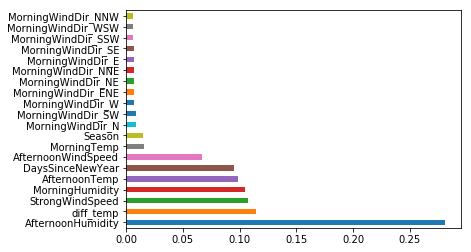

In [8]:
features_importance = pd.Series(index=X_train.columns,data=clf.feature_importances_)
features_importance.nlargest(20).plot.barh()

In [17]:
result = test.copy()
X_submit = read_and_process(test)
result['TomorrowRainForecast'] = clf.predict_proba(X_submit)[:,1]
result[['ID','TomorrowRainForecast']].to_csv('../data/submission3.csv',index=False)